In [7]:
import re  # 正则表达式匹配
import joblib

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#matplotlib inline

seed = 2020
train_path = "../data/train.txt"
test_path = "../data/test.txt"
train_process_path = "../data/train_precessed.txt"
test_process_path = "../data/test_processed.txt"

labels_dict = {'Cause-Effect': '0', 'Instrument-Agency': '1', 'Product-Producer': '2',
                   'Content-Container': '3', 'Entity-Origin': '4', 'Entity-Destination': '5',
                   'Component-Whole': '6', 'Member-Collection': '7', 'Message-Topic': '8',
                   'Other': '9'}

# 定义类别列表
LABEL_INDEX = ['Cause-Effect', 'Instrument-Agency', 'Product-Producer',
               'Content-Container', 'Entity-Origin', 'Entity-Destination',
               'Component-Whole', 'Member-Collection', 'Message-Topic', 'Other']

In [8]:
def generate_data_train(path): #预处理训练集
    target_path = path
    e1_list, e2_list, text_list = [], [], [] # 实体1，实体2，句子对应的list
    label = []
    with open(target_path,"r", encoding='utf-8') as f:
        for line in f:
            raw_text = line.strip()
            number = raw_text[0].isdigit()
            if number:
                raw_text = raw_text.split('.')[0] #提取句子,以句子结尾作为分割
                index = raw_text.find("\"")
                raw_text = raw_text[index+1:]
                raw_text = raw_text.replace('.','') #删除句号
                text_list.append(raw_text)
            else:
               entity = raw_text.split('(')
               relation = entity[0]
               label.append(relation)
               e1 = entity[1].split(',')[0]   #提取两个实体
               e2 = (entity[1].split(',')[1]).split(')')[0]
               e1_list.append(e1)
               e2_list.append(e2)

    with open(train_process_path,"w",encoding='utf-8') as f:
        for i in range(len(text_list)):
            f.write(e1_list[i]+ '\t' + e2_list[i] +'\t' +  label[i] +'\t' + text_list[i] + '\n')
        f.close()


def generate_data_test(path):  #预处理测试集
    target_path = path
    text_list = []
    with open(target_path,"r", encoding='utf-8') as f:
        for line in f:
            raw_text = line.strip()
            raw_text = raw_text.split('"')[1]
            raw_text = raw_text.replace('.', '')  # 删除句号
            text_list.append(raw_text)
    #print(len(text_list))  1600
    with open(test_process_path,"w",encoding='utf-8') as f:
        for i in range(len(text_list)):
            f.write( text_list[i] + '\n')
        f.close()

def read_data(path):
    label_list, text_list = [], []
    k = 0
    with open(path, 'r', encoding='utf-8') as f:
        for line in f :
            k += 1
            text = line.strip().split('\t')
            label_list.append(labels_dict[text[2]]) #返回label的值
            #print(k)
            #print(line)
            text_list.append(text[3])
    return text_list, label_list

In [9]:
def read_test_data(path):
    text_list = []
    k = 0
    with open(path, 'r', encoding= 'utf-8') as f:
        for line in f :
            text =line.strip().split('\n')
            text = text[0]
            text_list.append(text)
    return text_list

In [10]:
x_test = read_test_data(test_process_path)

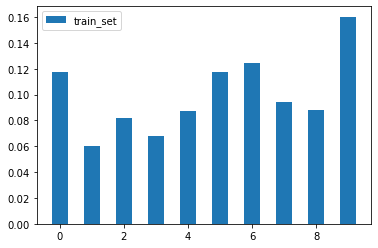

In [11]:
if __name__ == '__main__':
    generate_data_train(train_path)
    generate_data_test(test_path)
    x_train, y_train = read_data(train_process_path)
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    x = [i for i in range(len(labels))]
    count_in_train = [y_train.count(label) / len(y_train) for label in labels]  # 统计训练集占比
    plt.figure()
    plt.bar(x, count_in_train, width=0.5, label="train_set")
    plt.legend()
    plt.show()

In [12]:
tfidf_model = TfidfVectorizer(stop_words='english').fit(x_train)
print(f'word_dict shape: {len(tfidf_model.vocabulary_)}')


word_dict shape: 16383


In [13]:
x_train_vec = tfidf_model.transform(x_train) # 节省空间，csr格式系数矩阵
x_test_vec = tfidf_model.transform(x_test)

In [14]:
print(type(x_train_vec))

<class 'scipy.sparse.csr.csr_matrix'>


In [15]:
clf = LogisticRegression(solver='liblinear')  # 求解器使用lbfgs，其他使用默认超参数
clf.fit(x_train_vec,y_train)

LogisticRegression(solver='liblinear')

In [16]:
import os 
if not os.path.exists('./temp/models'):
    os.makedirs('./temp/models')

joblib.dump(clf,"./temp/models/base_model.joblib")
joblib.dump(tfidf_model, "./temp/models/base_vectorizer.joblib")

['./temp/models/base_vectorizer.joblib']

In [17]:
y_test = clf.predict(x_test_vec)
y_test[1:10]

array(['9', '2', '9', '6', '9', '0', '9', '9', '9'], dtype='<U1')

In [18]:
# 定义类别列表
LABEL_INDEX = ['Cause-Effect', 'Instrument-Agency', 'Product-Producer',
               'Content-Container', 'Entity-Origin', 'Entity-Destination',
               'Component-Whole', 'Member-Collection', 'Message-Topic', 'Other']

In [19]:
with open('./result/results.txt','w', encoding='utf-8') as f:
    for i in range(len(y_test)):
        line = LABEL_INDEX[int(y_test[i])]
        f.write(str(line) + '\n')

In [20]:
result_text = []
with open('./result/results.txt','r', encoding='utf-8') as f:
    for line in f:
        text =line.strip().split('\n')
        text = text[0]
        result_text.append(text)

In [21]:
print(len(result_text),result_text[1:10])

1600 ['Other', 'Product-Producer', 'Other', 'Component-Whole', 'Other', 'Cause-Effect', 'Other', 'Other', 'Other']


In [59]:
from random import randint, sample
val = sorted(val)
val_complement =  list(set([i for i in range(6400) ])-set(val))
x_val = [x_train[i] for i in val]
y_val = [y_train[i] for i in val]

x_train = [x_train[i] for i in val_complement]
y_train = [y_train[i] for i in val_complement]

[18,
 27,
 29,
 39,
 44,
 54,
 65,
 83,
 115,
 118,
 120,
 122,
 133,
 138,
 226,
 231,
 250,
 258,
 271,
 282,
 295,
 332,
 352,
 353,
 366,
 372,
 407,
 414,
 421,
 422,
 433,
 454,
 489,
 521,
 535,
 546,
 573,
 597,
 606,
 616,
 658,
 663,
 721,
 815,
 819,
 828,
 834,
 840,
 843,
 879,
 895,
 920,
 940,
 951,
 1050,
 1098,
 1131,
 1154,
 1157,
 1178,
 1181,
 1205,
 1210,
 1221,
 1242,
 1247,
 1254,
 1268,
 1277,
 1294,
 1331,
 1336,
 1339,
 1340,
 1344,
 1382,
 1390,
 1397,
 1398,
 1412,
 1416,
 1436,
 1457,
 1459,
 1473,
 1486,
 1513,
 1527,
 1563,
 1578,
 1611,
 1658,
 1665,
 1703,
 1720,
 1726,
 1736,
 1750,
 1756,
 1772,
 1802,
 1816,
 1821,
 1822,
 1837,
 1841,
 1854,
 1866,
 1869,
 1870,
 1890,
 1895,
 1896,
 1915,
 1925,
 1930,
 1945,
 1949,
 1966,
 1977,
 1986,
 2002,
 2022,
 2045,
 2060,
 2067,
 2085,
 2095,
 2104,
 2113,
 2118,
 2120,
 2126,
 2149,
 2151,
 2183,
 2184,
 2209,
 2211,
 2214,
 2224,
 2246,
 2259,
 2290,
 2300,
 2329,
 2344,
 2358,
 2366,
 2382,
 2400,
 2402

In [34]:
x_train[1]

'The child was carefully wrapped and bound into the cradle by means of a cord'

In [30]:
for i in val:
    print(i)

18
27
29
39
44
54
65
83
115
118
120
122
133
138
226
231
250
258
271
282
295
332
352
353
366
372
407
414
421
422
433
454
489
521
535
546
573
597
606
616
658
663
721
815
819
828
834
840
843
879
895
920
940
951
1050
1098
1131
1154
1157
1178
1181
1205
1210
1221
1242
1247
1254
1268
1277
1294
1331
1336
1339
1340
1344
1382
1390
1397
1398
1412
1416
1436
1457
1459
1473
1486
1513
1527
1563
1578
1611
1658
1665
1703
1720
1726
1736
1750
1756
1772
1802
1816
1821
1822
1837
1841
1854
1866
1869
1870
1890
1895
1896
1915
1925
1930
1945
1949
1966
1977
1986
2002
2022
2045
2060
2067
2085
2095
2104
2113
2118
2120
2126
2149
2151
2183
2184
2209
2211
2214
2224
2246
2259
2290
2300
2329
2344
2358
2366
2382
2400
2402
2422
2443
2444
2459
2470
2471
2477
2485
2492
2501
2505
2534
2550
2560
2564
2586
2604
2639
2644
2677
2678
2713
2718
2725
2729
2752
2767
2782
2791
2799
2835
2842
2851
2863
2871
2876
2908
2923
2934
2939
2947
2959
2969
3011
3040
3052
3086
3102
3128
3134
3141
3146
3177
3181
3218
3221
3232
3274
3279
3290
33

400

In [22]:
val

[5605,
 454,
 1945,
 2209,
 1841,
 546,
 2534,
 1050,
 4086,
 3441,
 895,
 5703,
 5668,
 2402,
 3673,
 1178,
 1658,
 2560,
 4160,
 3632,
 4341,
 2067,
 1277,
 5439,
 5442,
 3389,
 4292,
 5066,
 2725,
 2002,
 5634,
 1344,
 3232,
 1986,
 2876,
 2126,
 2443,
 5564,
 2718,
 663,
 2470,
 843,
 920,
 2045,
 1340,
 2184,
 3633,
 6089,
 4359,
 1772,
 1854,
 4929,
 5888,
 3804,
 1925,
 5422,
 6219,
 2211,
 6175,
 6261,
 4132,
 4557,
 3336,
 1382,
 250,
 5384,
 2459,
 940,
 3279,
 1098,
 6159,
 5007,
 1949,
 4112,
 2713,
 5670,
 3401,
 18,
 3290,
 5810,
 819,
 5981,
 2095,
 6188,
 2113,
 5146,
 2344,
 4770,
 1720,
 115,
 3435,
 353,
 3672,
 2586,
 6034,
 5360,
 1563,
 4428,
 5487,
 2644,
 1930,
 2246,
 5771,
 1816,
 3841,
 3773,
 573,
 2492,
 3827,
 2923,
 44,
 332,
 3599,
 3790,
 2104,
 258,
 6140,
 5925,
 433,
 226,
 4863,
 6082,
 5523,
 2959,
 6183,
 2471,
 489,
 5690,
 2485,
 1821,
 2022,
 2149,
 5963,
 39,
 2908,
 4788,
 4864,
 2422,
 4042,
 3983,
 5493,
 1157,
 5515,
 4638,
 6303,
 4158,
 

6400


None
